<a href="https://colab.research.google.com/github/prasann25/colab/blob/main/04_transfer_learning_in_tensorflow-part1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning With TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are 2 main benefits :
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [1]:
# Are we using a GPU?
!nvidia-smi

Mon Jul 12 01:06:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [2]:
# Get data(10% of food classes from Food101) https://www.kaggle.com/dansbecker/food-101
import zipfile

#Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()


--2021-07-12 01:06:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 2607:f8b0:400e:c00::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   182MB/s    in 0.9s    

2021-07-12 01:06:19 (182 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [3]:
# How many images in each folder
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent") :
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.'")

There are 2 directories and 0 images in '10_food_classes_10_percent'.'
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.'
There are 0 directories and 250 images in '10_food_classes_10_p

## Creating data loaders(preparing the data)
We'll use the `ImageDataGenerator` class to load in out images in batches.

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE=(224, 224)
BATCH_SIZE=32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen  = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir, 
                                                          target_size=IMG_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMG_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")





Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [5]:
len(train_data_10_percent), len(test_data)

(24, 79)

## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks :
* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training( before it trains too long and overfits) with the EarlyStopping callback

In [6]:
# Create TensorBoard callback (functionized becaused we need to create a new one for each model)

import datetime

def create_tensorboard_callback(dir_name, experiment_name) :
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log file to: {log_dir}")
  return tensorboard_callback

## Creating Models using TensorFlow Hub

In the past we'v e used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.
We can access pre-trained models on [https://www.tensorflow.org/hub](https://www.tensorflow.org/hub)


Research paper on which architecture is performing well on different classfication models
[https://paperswithcode.com](https://paperswithcode.com/)

https://paperswithcode.com/task/image-classification

Browsing the TensorFlow Hub page and sorting for image classification, we found the following vector model link : https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1



In [7]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [8]:
IMG_SHAPE + (3,)

(224, 224, 3)

In [9]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [10]:
# Let's make a create_model() function to create model from a URL
def create_model(model_url, num_classes=10) :
  """
  Take a tensorflow hub url and creates a Keras Sequential model with it.

  Args:
    model_url(str) : A TensorFlow Hub feature extraction URL.
    num_classes(int) : Number of output neurons in the output layer,
      should be equal to number of target classes, default to 10.
  Returns :
    An uncompiled Keras Sequential mdoel with model_url as feature extractor 
    layer and Dense output layer with num_classes output neurons.
  """

  # Download the pretrained model and saves it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url, 
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape = IMG_SHAPE + (3, ))
  
  # Create our own model
  model = tf.keras.Sequential([
          feature_extractor_layer,
          layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [11]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [12]:
# Compile our resnet model
resnet_model.compile(loss = "categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

In [13]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [14]:
resnet_history = resnet_model.fit(train_data_10_percent, 
                                  epochs=5, 
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log file to: tensorflow_hub/resnet50V2/20210712-010747
Epoch 1/5
24/24 [==============================] - 25s 821ms/step - loss: 1.9801 - accuracy: 0.3200 - val_loss: 1.2210 - val_accuracy: 0.6024
Epoch 2/5
24/24 [==============================] - 16s 682ms/step - loss: 0.9138 - accuracy: 0.7293 - val_loss: 0.8436 - val_accuracy: 0.7304
Epoch 3/5
24/24 [==============================] - 16s 678ms/step - loss: 0.6188 - accuracy: 0.8293 - val_loss: 0.7542 - val_accuracy: 0.7588
Epoch 4/5
24/24 [==============================] - 16s 679ms/step - loss: 0.4772 - accuracy: 0.8720 - val_loss: 0.6980 - val_accuracy: 0.7788
Epoch 5/5
24/24 [==============================] - 16s 679ms/step - loss: 0.3762 - accuracy: 0.9120 - val_loss: 0.6665 - val_accuracy: 0.7804


wow! 

That is incredible. Our transfer learning feature exxtractor mdoel out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time AND with only 10% of the training examples.


In [17]:
# Let's create a function plot our loss curves...
# Note: You could put a function lie this into a script called helper.py and import it when you need it...
import matplotlib.pyplot as plt

def plot_loss_curves(history) :
  """
    Return separate loss curves for training and validation metrics...

    Args :
      history : TensorFlow History object.
    Returns :
      Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"])) # how many epochs we run for?

  #Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()


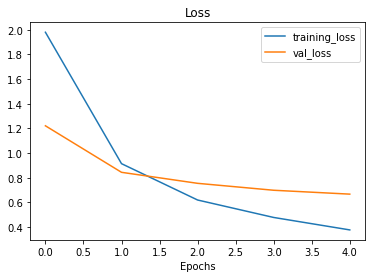

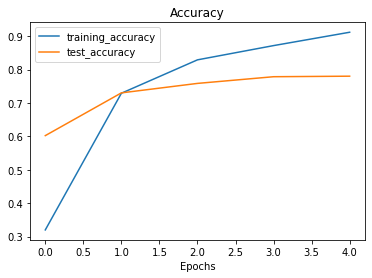

In [18]:
plot_loss_curves(resnet_history)

### Creating and Testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [19]:
# Create EfficientNetB0 model
# Details on EfficientNet https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html
efficientnet_model = create_model(efficientnet_url,
                            num_classes=train_data_10_percent.num_classes)


In [21]:
# Compile the model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])


In [22]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [23]:
# Fit the efficientnet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, 
                       epochs=5, 
                       steps_per_epoch=len(train_data_10_percent),
                       validation_data= test_data,
                       validation_steps=len(test_data),
                       callbacks =[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                               experiment_name="efficientnetb0"
                                                               )])


Saving TensorBoard log file to: tensorflow_hub/efficientnetb0/20210712-014545
Epoch 1/5
24/24 [==============================] - 26s 807ms/step - loss: 1.8466 - accuracy: 0.4587 - val_loss: 1.2803 - val_accuracy: 0.7380
Epoch 2/5
24/24 [==============================] - 15s 654ms/step - loss: 1.0622 - accuracy: 0.7800 - val_loss: 0.8607 - val_accuracy: 0.8276
Epoch 3/5
24/24 [==============================] - 15s 649ms/step - loss: 0.7604 - accuracy: 0.8267 - val_loss: 0.6952 - val_accuracy: 0.8500
Epoch 4/5
24/24 [==============================] - 15s 651ms/step - loss: 0.6110 - accuracy: 0.8587 - val_loss: 0.6106 - val_accuracy: 0.8588
Epoch 5/5
24/24 [==============================] - 15s 647ms/step - loss: 0.5187 - accuracy: 0.8867 - val_loss: 0.5578 - val_accuracy: 0.8652


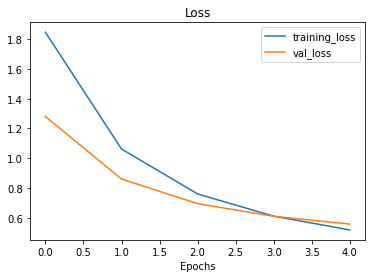

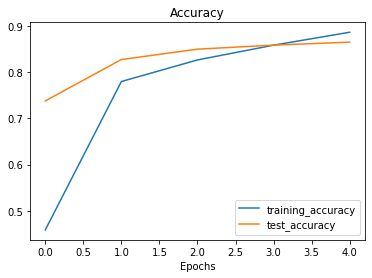

In [24]:
# Loss curve for Efficient Net 50
plot_loss_curves(efficientnet_history)